# Comparing two normal distributions 

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [2]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## The story

![traffic](..\images\traffic.jpg)

> Let's image that you have collected some data on highway driving. You are measuring speed, in km/h. Some people were driving manually, whereas some others were using adaptive cruise control (ACC). You want to investigate if there is any difference in speed--at aggregate level--between manual driving and driving with ACC. The hypothesis is that ACC, by automating the longitudinal control of the car, will reduce the driver variability on the speed.

## Generate artificial data

In [4]:
mu_real = np.array([90, 100])
sd_real = np.array([10, 3])

n_samples = np.array([100, 100])
factor_levels = np.array(['Manual', 'ACC'])

In [5]:
# Random seed need to be in the same cell.
np.random.seed(SEED)

data = pd.DataFrame(data={
    'speed':np.concatenate(
        [np.random.normal(loc=mu_real[i], scale=sd_real[i], size=n_samples[i]) for i, _ in enumerate(factor_levels)]
    ), 
    'driving_mode':np.repeat(factor_levels, n_samples)
                          })
         
data.driving_mode = pd.Categorical(data.driving_mode, categories=['Manual', 'ACC'], ordered=False)
data.head()

,speed,driving_mode
0,99.259215,Manual
1,63.437963,Manual
2,95.912173,Manual
3,95.210851,Manual
4,106.657916,Manual


In [6]:
data.groupby('driving_mode').agg(['mean', 'std'])

speed           
                    mean        std
driving_mode                       
Manual         90.125569  10.675811
ACC           100.121771   2.933147

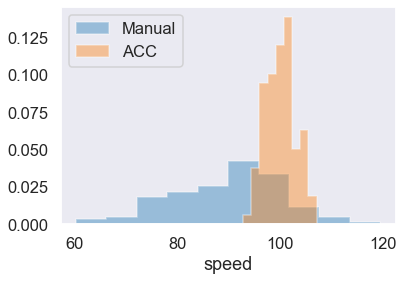

In [7]:
for cat in data.driving_mode.cat.categories:
    sns.distplot(data[data.driving_mode==cat].speed, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled'})

plt.legend();

A first look suggests that manual driving has higher speed variability than ACC driving. Moreover, it seems that, on average, the speed is lower in manual driving than in ACC driving. A possible explanation is that the activation of ACC reduce the human variability in maintaining the speed and the headway to the lead vehicle.

We will estimate the difference in average speed and variability with Bayesian modelling. Thanks to the Bayesian method we will also obtain the uncertainty of the estimation. 

## Bayesian modelling

In [8]:
# Sampler settings
BURNIN=1000
TUNE=1000
SAMPLES=1000

### Build the model

In [9]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=data['speed'].mean(), sd=50, shape=2)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50, shape=2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu[data['driving_mode'].cat.codes.values], 
                                         sd=sd[data['driving_mode'].cat.codes.values], observed=data['speed'].values)
    
    delta_mu = pm.Deterministic('delta_mu', mu[1]-mu[0])
    delta_sd = pm.Deterministic('delta_sd', sd[1]-sd[0])

In [10]:
model.check_test_point()

mu             -9.66
sd_log__       -1.54
likelihood   -926.42
Name: Log-probability of test_point, dtype: float64

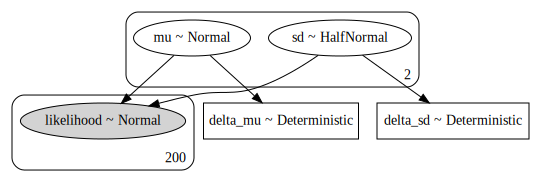

In [11]:
# Download graphviz to run
# pm.model_to_graphviz(model)

### Sample from the model

In [11]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 294 seconds.


### Diagnose the sampling

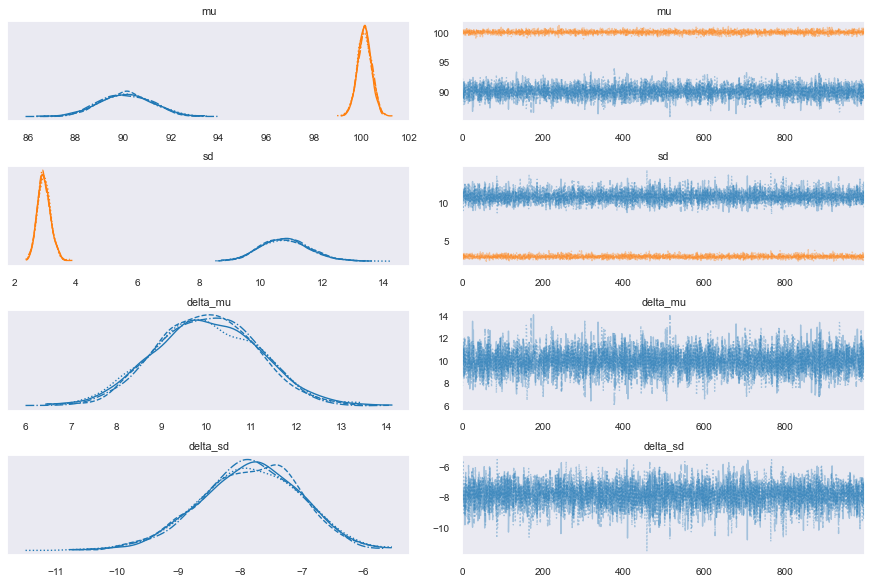

In [12]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

### Summarize the posterior density

In [13]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],90.11,1.08,88.02,92.01,0.01,0.01,6591.0,6590.0,6584.0,3058.0,1.0
mu[1],100.12,0.29,99.60,100.70,0.00,0.00,6231.0,6229.0,6222.0,2944.0,1.0
sd[0],10.82,0.79,9.34,12.24,0.01,0.01,6189.0,6144.0,6127.0,3326.0,1.0
sd[1],2.97,0.21,2.60,3.41,0.00,0.00,6108.0,5938.0,6254.0,3112.0,1.0
delta_mu,10.01,1.12,8.00,12.13,0.01,0.01,6197.0,6144.0,6190.0,3212.0,1.0
delta_sd,-7.85,0.82,-9.34,-6.32,0.01,0.01,6430.0,6368.0,6397.0,3074.0,1.0


### Posterior predictive check

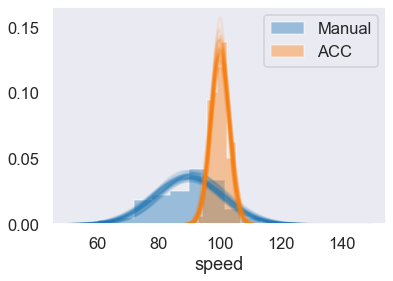

In [14]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(50, 150, 0.5)

for cat in data.driving_mode.cat.categories:
    sns.distplot(data[data.driving_mode==cat].speed, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled'})

for i, group in enumerate(data['driving_mode'].cat.categories): 
    for mu, sd in zip(trace['mu'][::THIN, i], trace['sd'][::THIN, i]):
        ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[i])

plt.legend();

The posterior predictive check suggests that our model generates credible observations, because the fit agrees well with the experimental data.

## Statistical inference

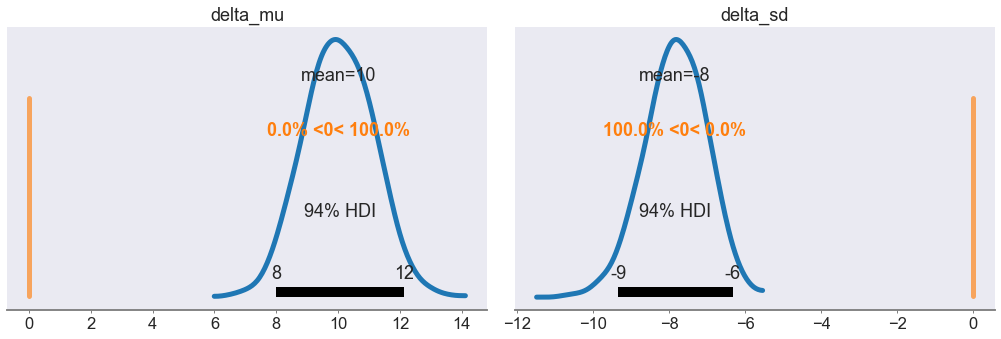

In [16]:
pm.plot_posterior(trace, varnames=['delta_mu', 'delta_sd'], ref_val=0, round_to=1,  lw=5);

Our research question was on the quantification of the difference in speed between manual driving and ACC driving. Given the data and our model, we can say that, on average, people driving with ACC maintained a speed 10km/h than in manual driving. Moreover, the ACC decreased the variability in speed compared to manual driving.

The higher posterior density (HPD) interval can be interpreted in probabilistic way. That is, we can state that, given our data and the model, there is 95% probability that the difference in average speed is between 8.0 and 12.2 km/h.